In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

sys.path.append("../..")
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

In [2]:
# Parameters
SHUFFLE_DATA = False
CELL_TYPE = "PBMC"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "Thapsigargin_1.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_Thapsigargin_1"

In [3]:
data = Path("../../MLP_utils/binary_config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

# overwrite params via command line arguments from papermill
params.CELL_TYPE = CELL_TYPE
params.MODEL_NAME = MODEL_NAME
params.CONTROL_NAME = CONTROL_NAME
params.TREATMENT_NAME = TREATMENT_NAME
params.MODEL_NAME = MODEL_NAME

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(f"../../../data/{params.CELL_TYPE}_preprocessed_sc_norm.parquet")

df = pq.read_table(file_path).to_pandas()

In [5]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [6]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025', 'DMSO_0.100_DMSO_0.025',
       'media_ctr_0_Media_ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'DMSO_0.100_Z-VAD-FMK_100.0',
       'DMSO_0.100_Z-VAD-FMK_30.0', 'LPS_10.000_Disulfiram_0.1',
       'LPS_10.000_Disulfiram_1.0', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.5_DMSO_0.025', 'Disulfiram_2.500_DMSO_0.025',
       'Topotecan_5.000_DMSO_0.025', 'Topotecan_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_2.5', 'LPS_10.000_Z-VAD-FMK_100.0',
       'H2O2_100.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_100.000_DMSO_0.025', 'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'H2O2_100.000_Disulfiram_1.0', 'H2O2_100.000_

In [7]:
paired_treatment_list = [
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_0.100_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_0.100_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Flagellin_1.000_Disulfiram_1.0"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_1.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_3.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_100.000_10.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_1.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_3.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_Nigericin_1.000_10.0_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "H2O2_100.000_Z-VAD-FMK_100.0"],
    ["DMSO_0.100_DMSO_0.025", "H2O2_100.000_DMSO_0.025"],
    ["LPS_100.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_100.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["LPS_0.010_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["LPS_0.010_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
]

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.67      0.93      0.78    215130
           1       0.81      0.37      0.51    159435

    accuracy                           0.70    374565
   macro avg       0.74      0.65      0.64    374565
weighted avg       0.73      0.70      0.66    374565



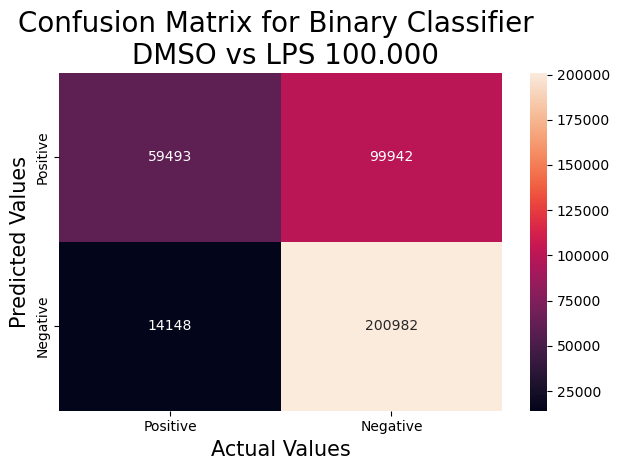

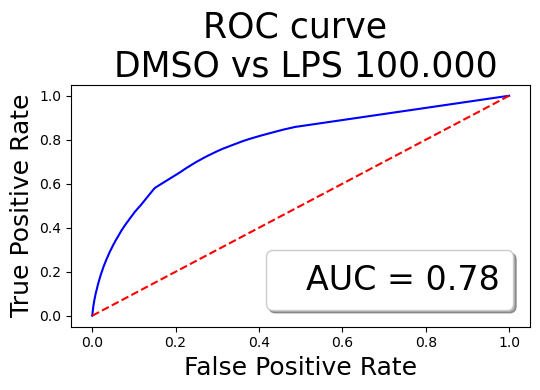

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.83      0.93      0.88    215130
           1       0.88      0.73      0.80    148456

    accuracy                           0.85    363586
   macro avg       0.86      0.83      0.84    363586
weighted avg       0.85      0.85      0.85    363586



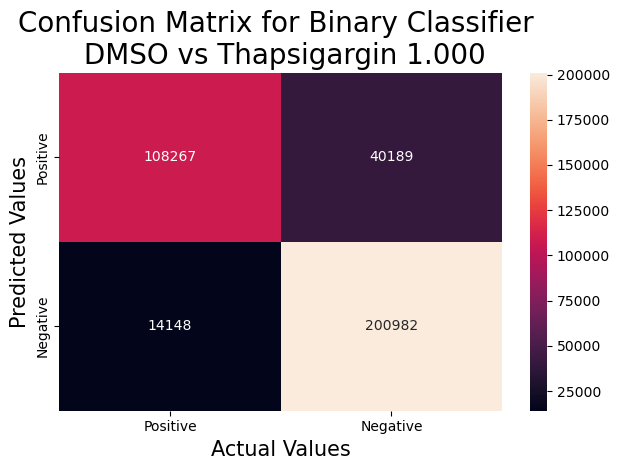

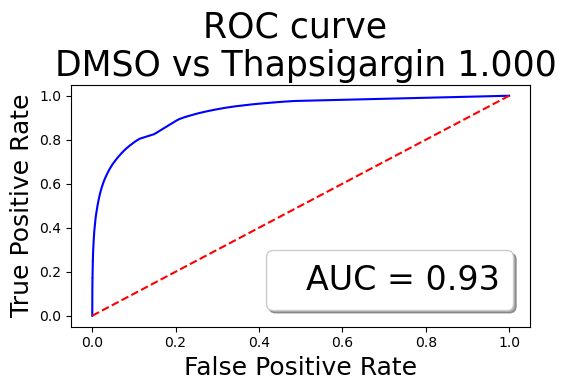

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.83      0.93      0.88    215130
           1       0.90      0.76      0.82    166984

    accuracy                           0.86    382114
   macro avg       0.87      0.84      0.85    382114
weighted avg       0.86      0.86      0.85    382114



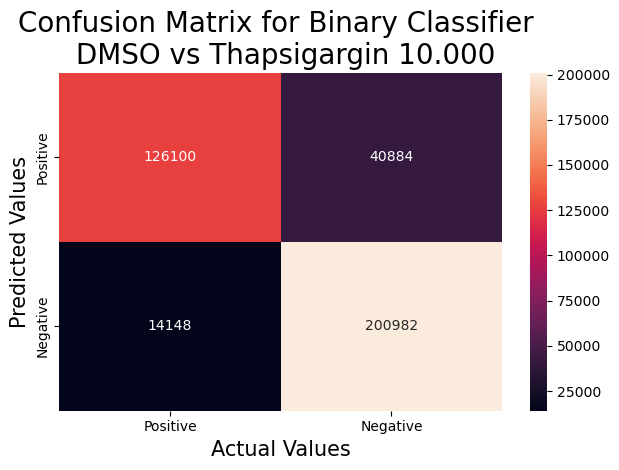

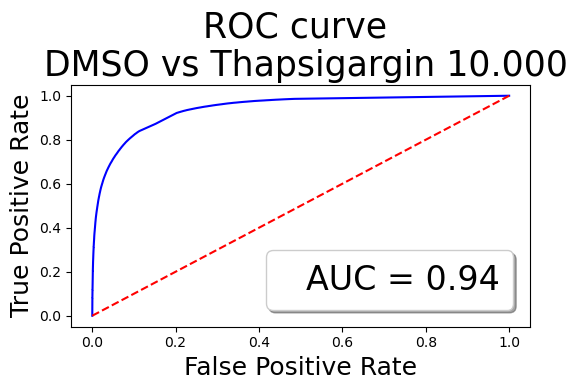

LPS_0.100_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.72      0.93      0.82    215130
           1       0.81      0.45      0.58    138597

    accuracy                           0.74    353727
   macro avg       0.77      0.69      0.70    353727
weighted avg       0.76      0.74      0.72    353727



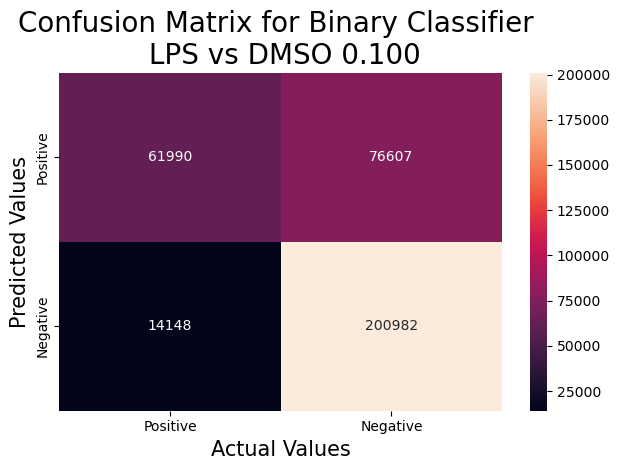

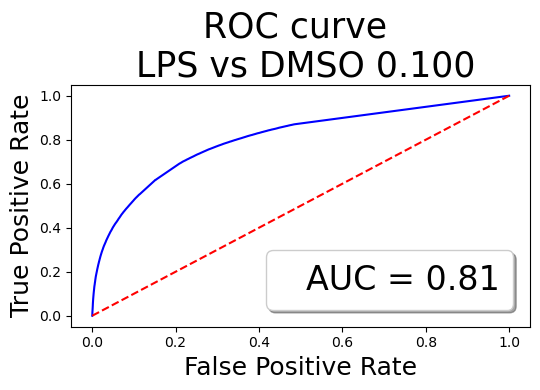

DMSO_0.100_DMSO_0.025 LPS_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.75      0.93      0.83    215130
           1       0.84      0.53      0.65    139433

    accuracy                           0.77    354563
   macro avg       0.80      0.73      0.74    354563
weighted avg       0.79      0.77      0.76    354563



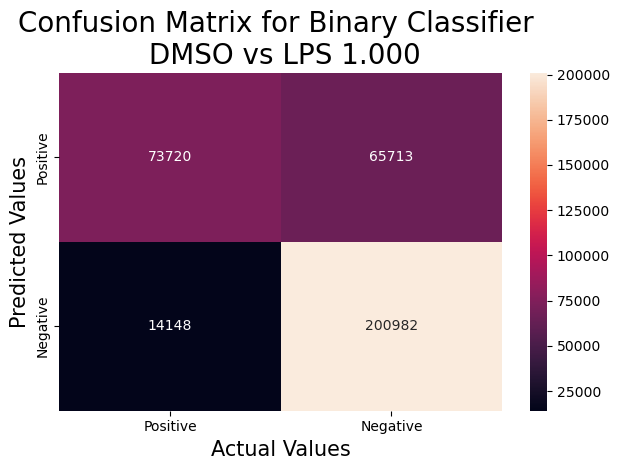

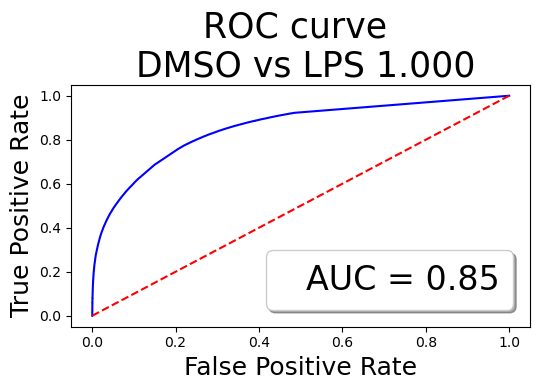

DMSO_0.100_DMSO_0.025 LPS_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.76      0.93      0.84    215130
           1       0.87      0.60      0.71    156490

    accuracy                           0.79    371620
   macro avg       0.82      0.77      0.77    371620
weighted avg       0.81      0.79      0.78    371620



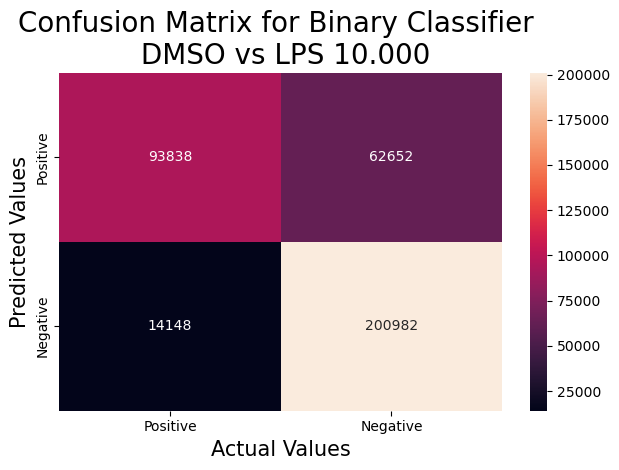

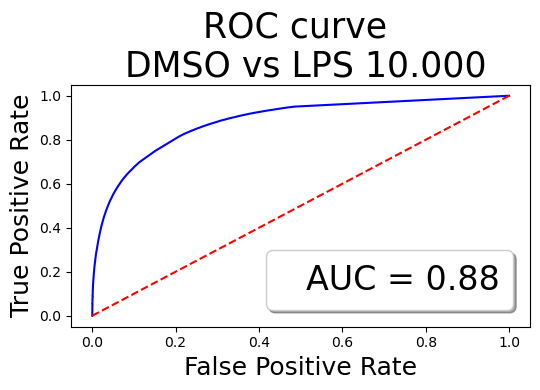

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.67      0.93      0.78    215130
           1       0.81      0.37      0.51    159435

    accuracy                           0.70    374565
   macro avg       0.74      0.65      0.64    374565
weighted avg       0.73      0.70      0.66    374565



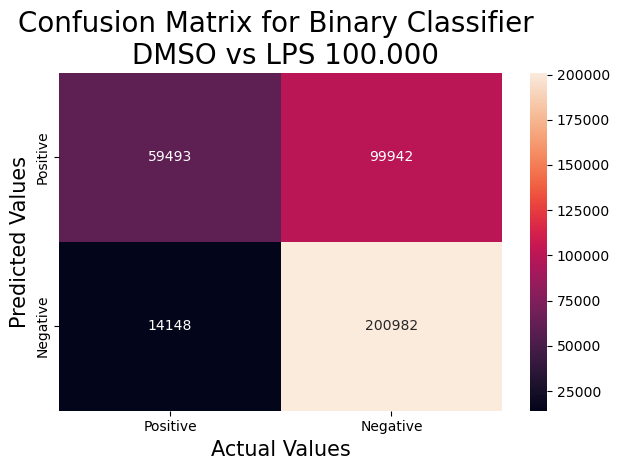

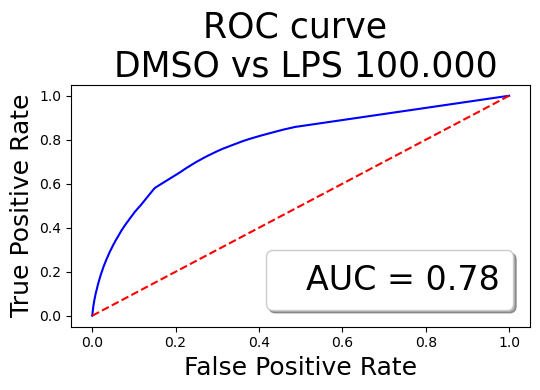

DMSO_0.100_DMSO_0.025 Flagellin_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.78      0.93      0.85    215130
           1       0.73      0.40      0.52     95915

    accuracy                           0.77    311045
   macro avg       0.75      0.67      0.68    311045
weighted avg       0.76      0.77      0.75    311045



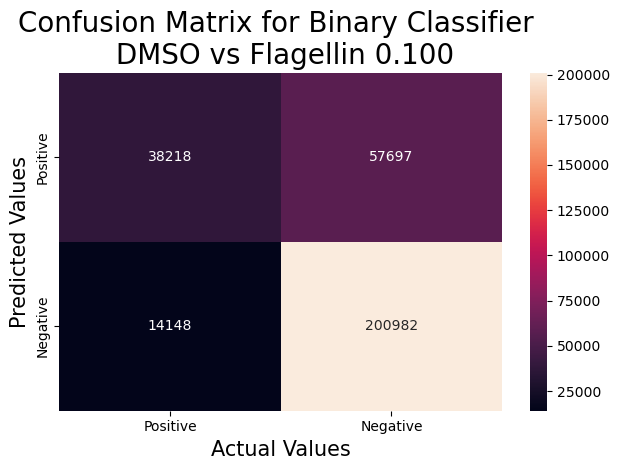

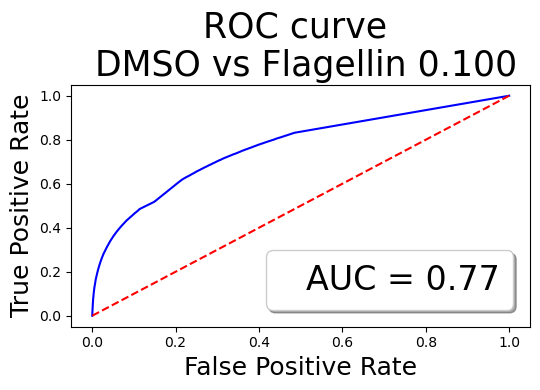

DMSO_0.100_DMSO_0.025 Flagellin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.78      0.93      0.85    215130
           1       0.77      0.46      0.57    104547

    accuracy                           0.78    319677
   macro avg       0.78      0.69      0.71    319677
weighted avg       0.78      0.78      0.76    319677



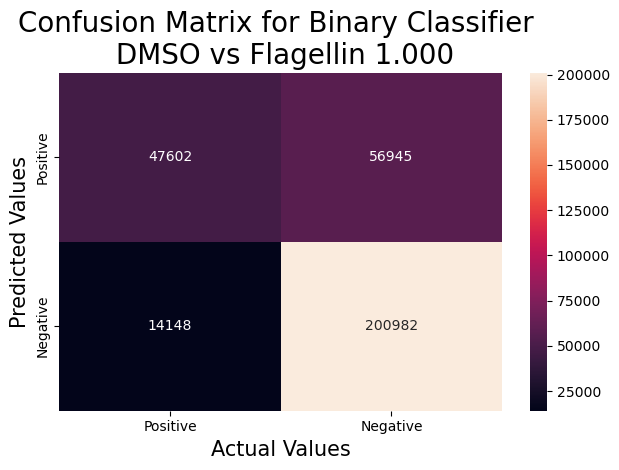

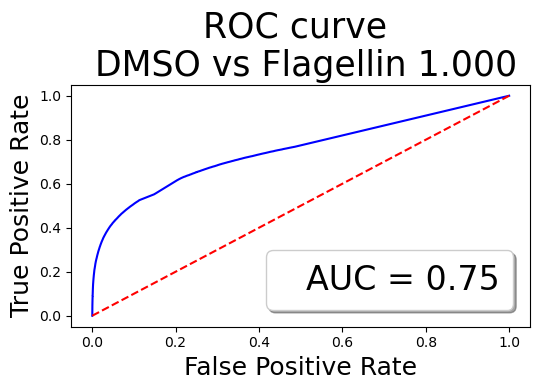

DMSO_0.100_DMSO_0.025 Flagellin_1.000_Disulfiram_1.0


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.83      0.93      0.88    215130
           1       0.88      0.72      0.79    145552

    accuracy                           0.85    360682
   macro avg       0.86      0.83      0.84    360682
weighted avg       0.85      0.85      0.85    360682



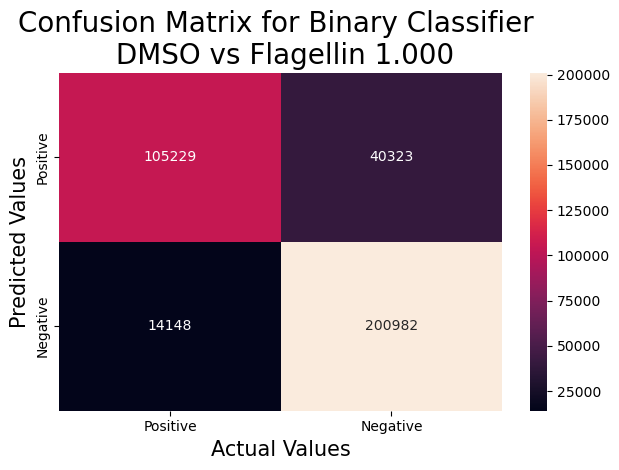

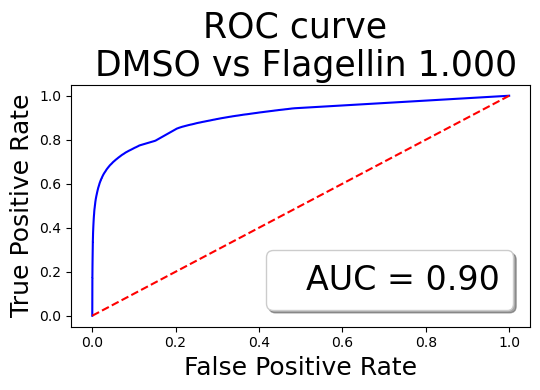

LPS_Nigericin_100.000_1.0_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.72      0.93      0.81    215130
           1       0.87      0.55      0.67    170659

    accuracy                           0.76    385789
   macro avg       0.80      0.74      0.74    385789
weighted avg       0.79      0.76      0.75    385789



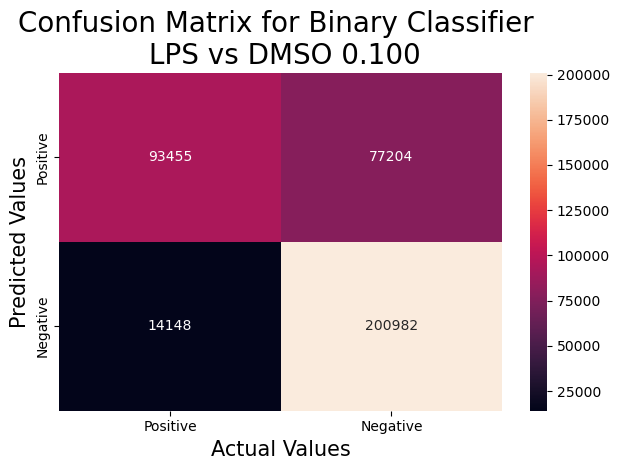

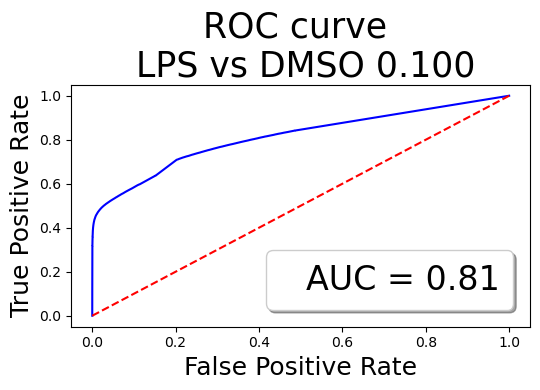

LPS_Nigericin_100.000_3.0_DMSO_0.025 DMSO_0.100_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.69      0.93      0.80    215130
           1       0.87      0.52      0.65    184854

    accuracy                           0.74    399984
   macro avg       0.78      0.73      0.73    399984
weighted avg       0.78      0.74      0.73    399984



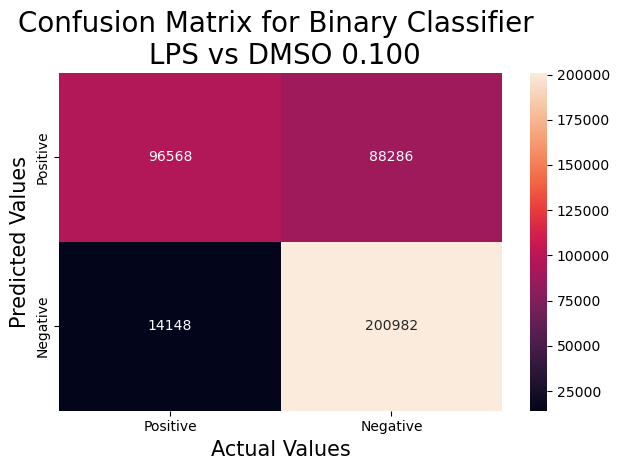

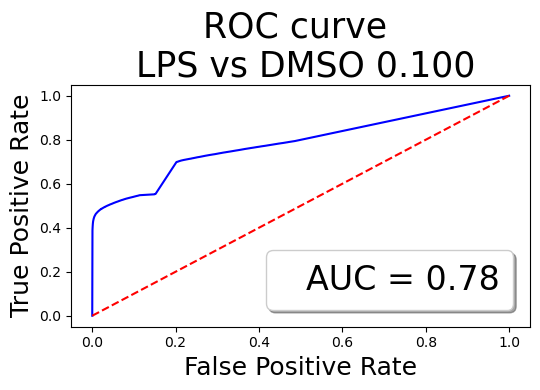

DMSO_0.100_DMSO_0.025 LPS_Nigericin_100.000_10.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.64      0.93      0.76    215130
           1       0.82      0.36      0.50    176090

    accuracy                           0.68    391220
   macro avg       0.73      0.65      0.63    391220
weighted avg       0.72      0.68      0.64    391220



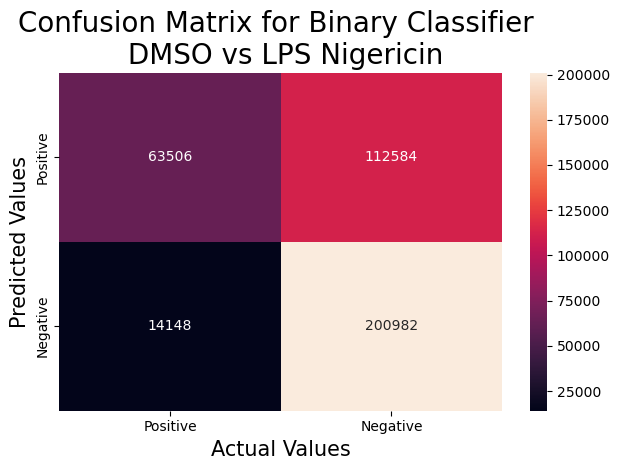

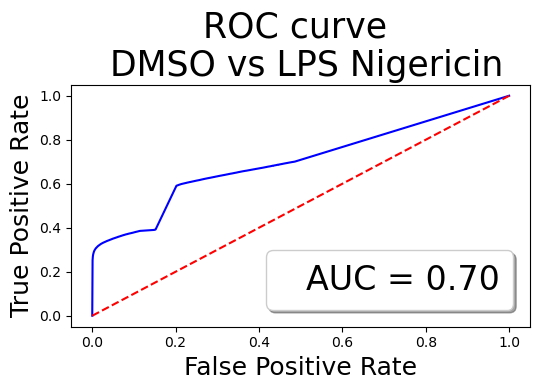

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_1.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.62      0.93      0.75    215130
           1       0.76      0.27      0.39    166013

    accuracy                           0.64    381143
   macro avg       0.69      0.60      0.57    381143
weighted avg       0.68      0.64      0.59    381143



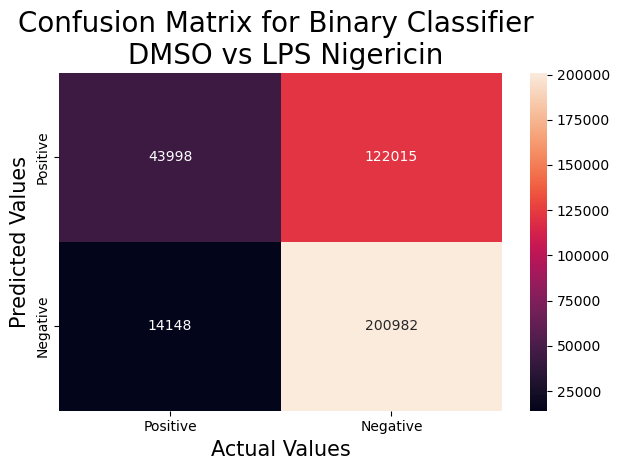

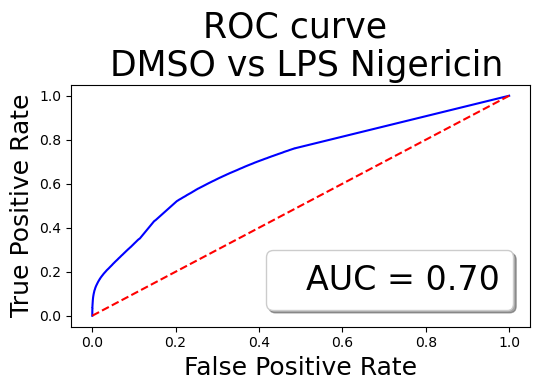

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_3.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.61      0.93      0.73    215130
           1       0.75      0.25      0.37    174261

    accuracy                           0.63    389391
   macro avg       0.68      0.59      0.55    389391
weighted avg       0.67      0.63      0.57    389391



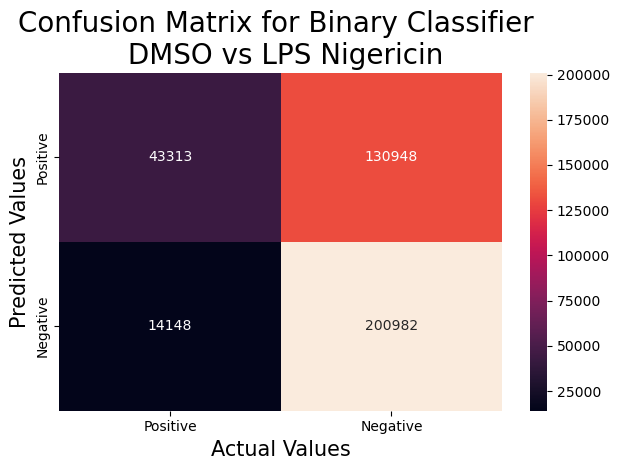

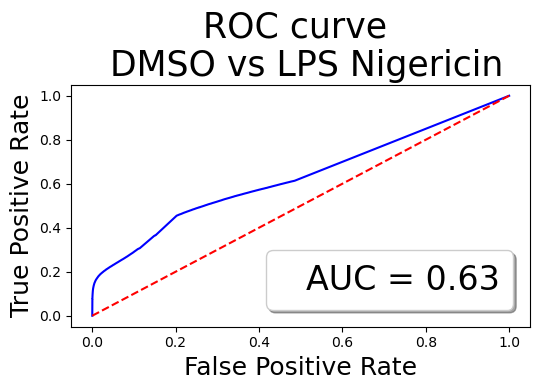

DMSO_0.100_DMSO_0.025 LPS_Nigericin_1.000_10.0_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.57      0.93      0.71    215130
           1       0.69      0.17      0.28    181166

    accuracy                           0.59    396296
   macro avg       0.63      0.55      0.49    396296
weighted avg       0.63      0.59      0.51    396296



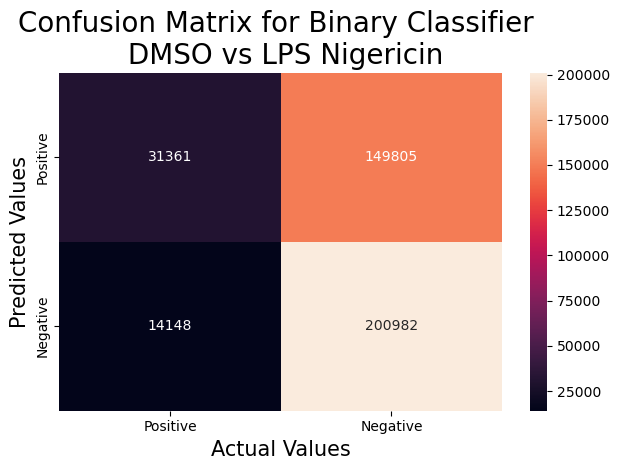

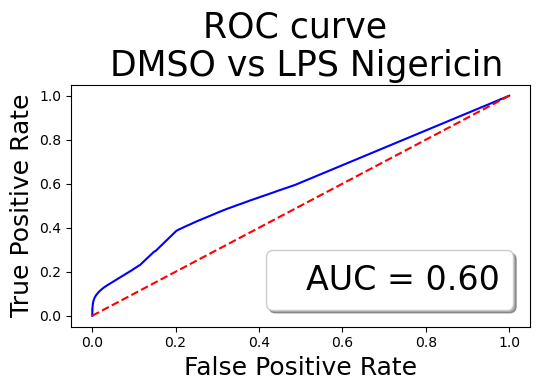

DMSO_0.100_DMSO_0.025 H2O2_100.000_Z-VAD-FMK_100.0


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.85      0.93      0.89    215130
           1       0.91      0.79      0.85    173437

    accuracy                           0.87    388567
   macro avg       0.88      0.86      0.87    388567
weighted avg       0.87      0.87      0.87    388567



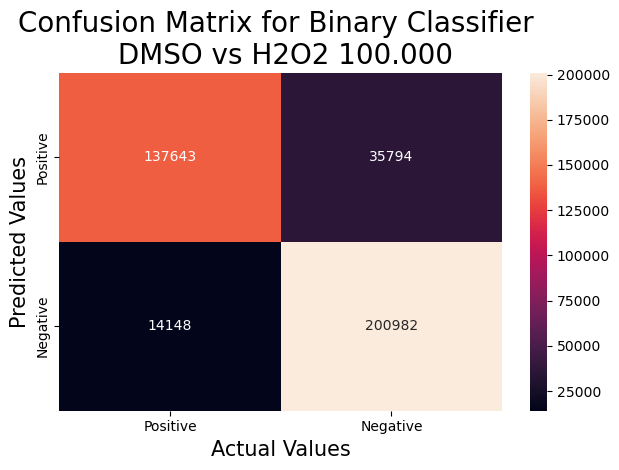

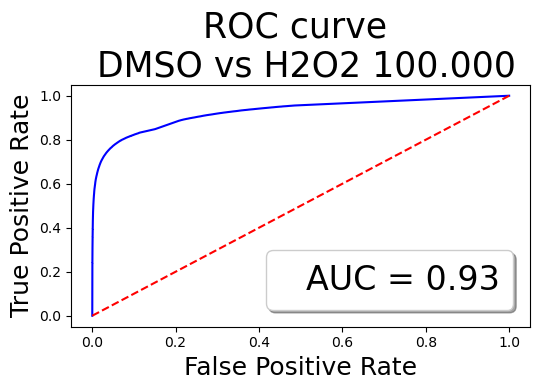

Thapsigargin_1.000_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.71      0.63      0.67    159435
           1       0.65      0.73      0.68    148456

    accuracy                           0.68    307891
   macro avg       0.68      0.68      0.68    307891
weighted avg       0.68      0.68      0.68    307891



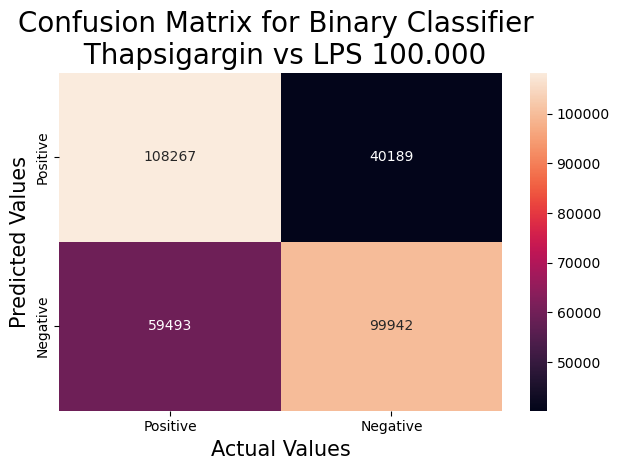

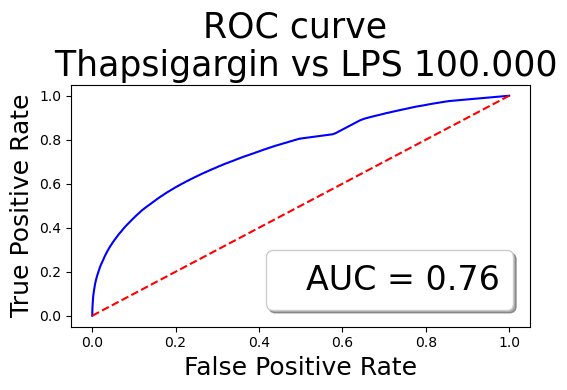

Thapsigargin_10.000_DMSO_0.025 LPS_100.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.71      0.63      0.67    159435
           1       0.68      0.76      0.72    166984

    accuracy                           0.69    326419
   macro avg       0.69      0.69      0.69    326419
weighted avg       0.69      0.69      0.69    326419



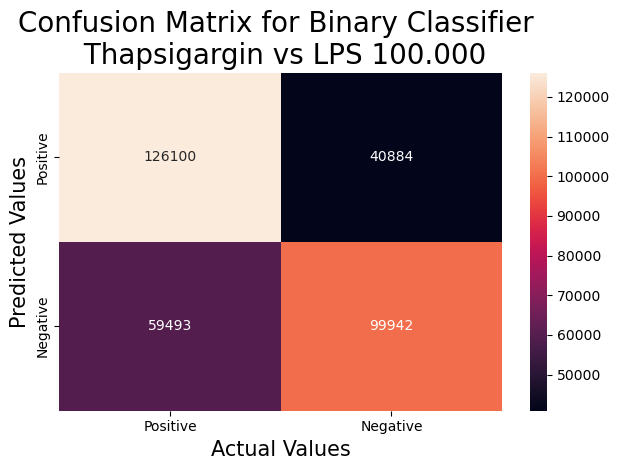

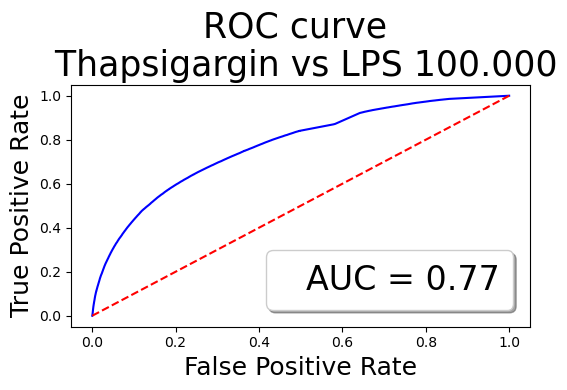

LPS_10.000_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.61      0.40      0.48    156490
           1       0.54      0.73      0.62    148456

    accuracy                           0.56    304946
   macro avg       0.57      0.56      0.55    304946
weighted avg       0.57      0.56      0.55    304946



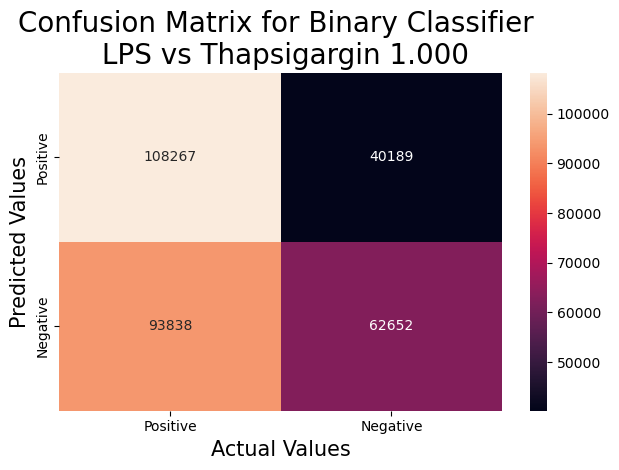

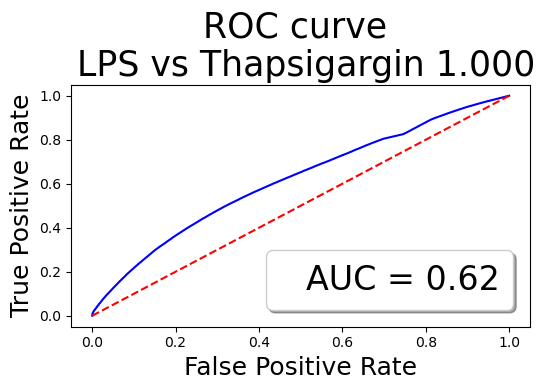

LPS_10.000_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.61      0.40      0.48    156490
           1       0.57      0.76      0.65    166984

    accuracy                           0.58    323474
   macro avg       0.59      0.58      0.57    323474
weighted avg       0.59      0.58      0.57    323474



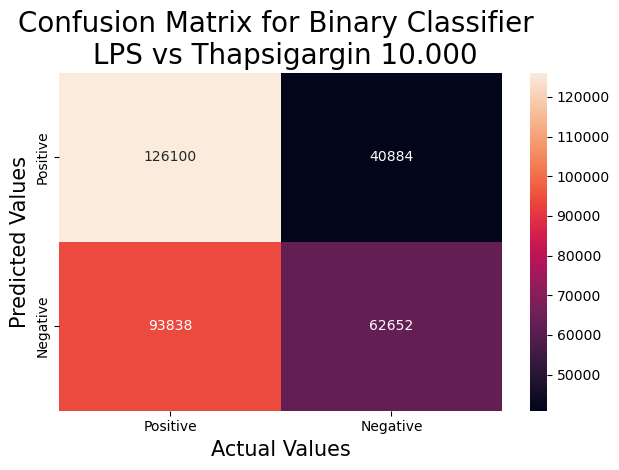

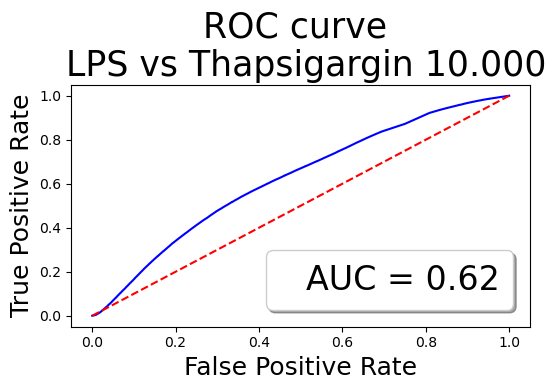

LPS_1.000_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.62      0.47      0.54    139433
           1       0.59      0.73      0.66    148456

    accuracy                           0.60    287889
   macro avg       0.61      0.60      0.60    287889
weighted avg       0.61      0.60      0.60    287889



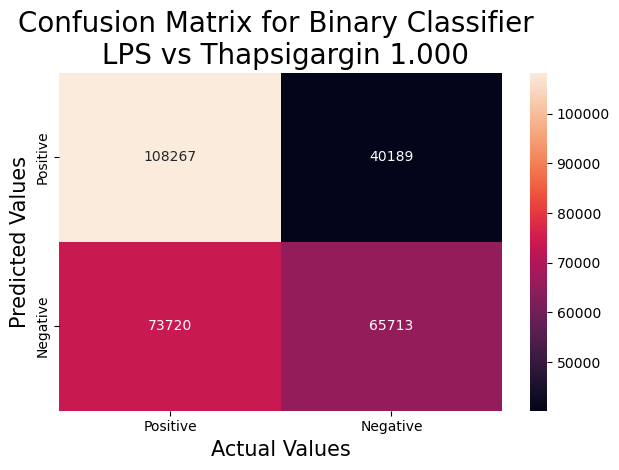

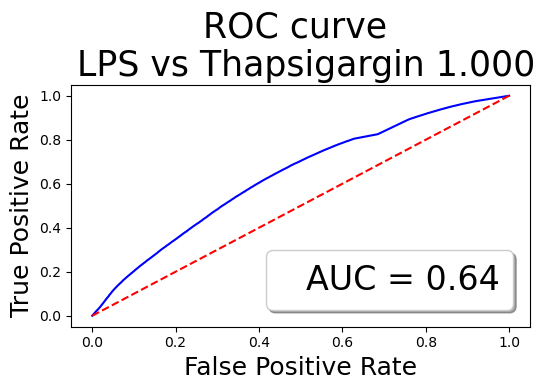

LPS_1.000_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.62      0.47      0.53    139433
           1       0.63      0.76      0.69    166984

    accuracy                           0.63    306417
   macro avg       0.62      0.61      0.61    306417
weighted avg       0.62      0.63      0.62    306417



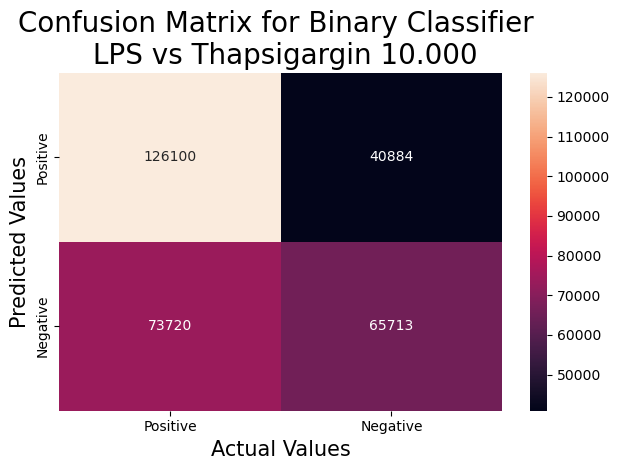

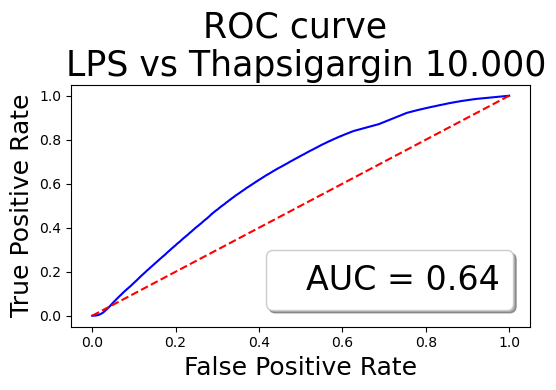

LPS_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.66      0.55      0.60    138597
           1       0.64      0.73      0.68    148456

    accuracy                           0.64    287053
   macro avg       0.65      0.64      0.64    287053
weighted avg       0.65      0.64      0.64    287053



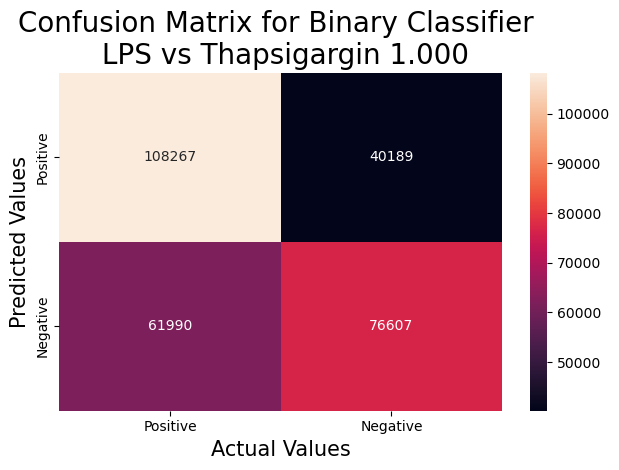

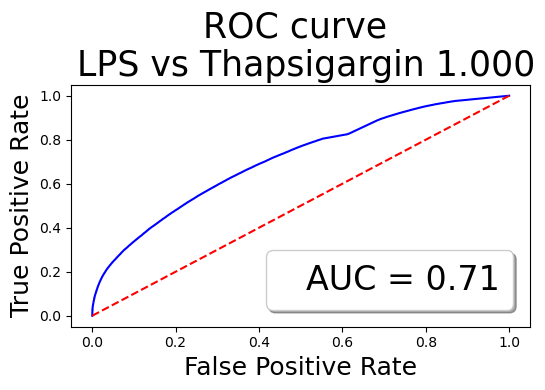

LPS_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.65      0.55      0.60    138597
           1       0.67      0.76      0.71    166984

    accuracy                           0.66    305581
   macro avg       0.66      0.65      0.65    305581
weighted avg       0.66      0.66      0.66    305581



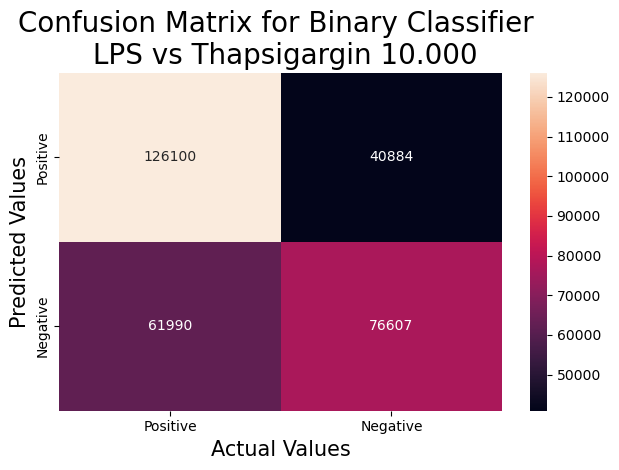

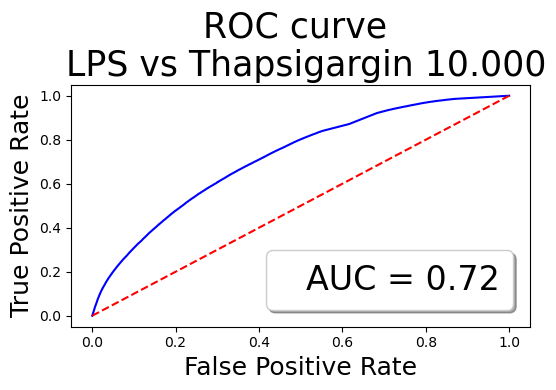

LPS_0.010_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.70      0.65      0.67    143080
           1       0.68      0.73      0.71    148456

    accuracy                           0.69    291536
   macro avg       0.69      0.69      0.69    291536
weighted avg       0.69      0.69      0.69    291536



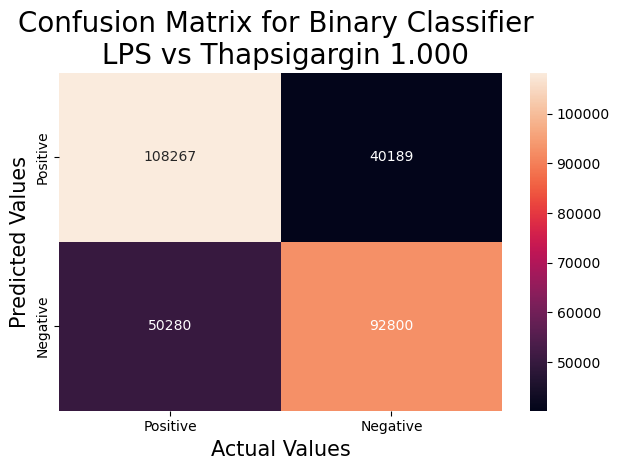

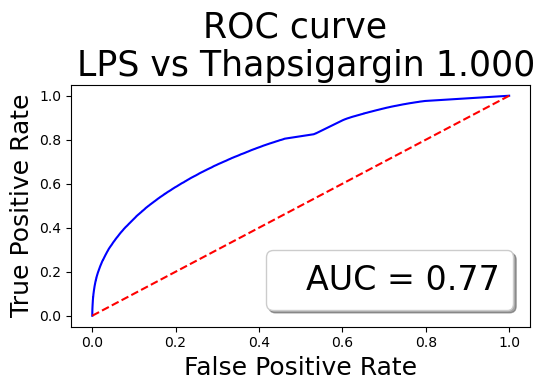

LPS_0.010_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025


Number of in features:  1245
Number of out features:  2
Binary_Classification


              precision    recall  f1-score   support

           0       0.69      0.65      0.67    143080
           1       0.71      0.76      0.73    166984

    accuracy                           0.71    310064
   macro avg       0.70      0.70      0.70    310064
weighted avg       0.71      0.71      0.71    310064



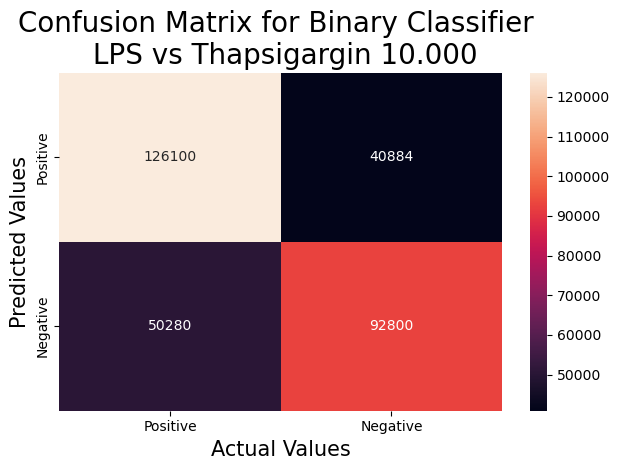

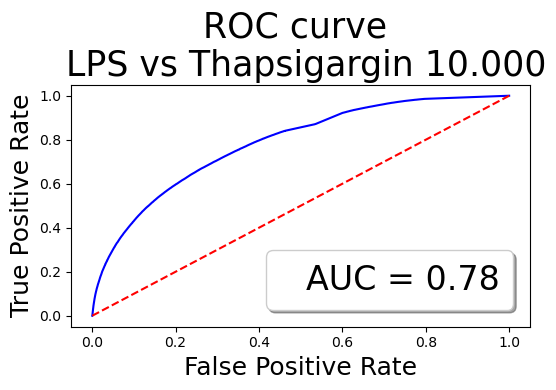

In [8]:
for i, j in paired_treatment_list:
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

    print(output_name)

    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    test_loop(test_df, output_name, title)